# Assignment 2
**Student Name:** Asma Islam  
**Dataset:** Stack Overflow NLP-tagged questions 

###  Data Collection Process

In [47]:
# import libraries
import requests
import pandas as pd
import time
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
nltk.download('stopwords')
import numpy as np
import html


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aipro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aipro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
#empty list to hold questions
 posts = []

#number of pages
pages = 200

#my API key to avoid errors
api_key = 'rl_A3Y9DG3U8GsbGUpb8vuvqr7U4'


In [49]:
#go through 200 pages to get questions with nlp tag
for page in range(1, pages + 1):
    print("Getting page", page)

    url = "https://api.stackexchange.com/2.3/questions"
    params = {
        'page': page,
        'pagesize': 100,
        'order': 'desc',
        'sort': 'votes',
        'tagged': 'nlp',
        'site': 'stackoverflow',
        'filter': '!9_bDDxJY5',
        'key': api_key
    }

    res = requests.get(url, params=params)

    if res.status_code == 200:
        data = res.json()
        for item in data['items']:
            if 'accepted_answer_id' in item:
                posts.append({
                    'question_id': item['question_id'],
                    'title': item['title'],
                    'body': item['body'],
                    'tags': item['tags'],
                    'accepted_answer_id': item['accepted_answer_id']
                })
    else:
        print("Failed on page", page)

    time.sleep(1.5)


In [50]:
#convert to dataframe and save it
df = pd.DataFrame(posts)
df.to_csv("nlp_questions_20000.csv", index=False)

In [51]:
# Load the dataset 
df = pd.read_csv("nlp_questions_20000.csv")

#view the dataset shape and columns
print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())

In [52]:
# Extract accepted answer IDs into a list
answer_ids = df['accepted_answer_id'].tolist()
chunks = [answer_ids[i:i + 100] for i in range(0, len(answer_ids), 100)]

In [53]:
#create a dictionary to store fetched answers
answers = {}

#API key 
api_key = 'rl_A3Y9DG3U8GsbGUpb8vuvqr7U4'

for i, chunk in enumerate(chunks):
    ids_string = ";".join(str(id) for id in chunk)
    url = f"https://api.stackexchange.com/2.3/answers/{ids_string}"
    params = {
        'site': 'stackoverflow',
        'filter': 'withbody',
        'key': api_key
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        for item in data['items']:
            answers[item['answer_id']] = item['body']
    else:
        print(f" Failed on chunk {i+1} of {len(chunks)} (status: {response.status_code})")

    time.sleep(1.5)

# Show how many answers were successfully fetched
print("Number of answers fetched:", len(answers))


In [54]:
df['accepted_answer'] = df['accepted_answer_id'].map(answers)
missing_answers = df['accepted_answer'].isna().sum()
print("Missing answers:", missing_answers)
df[['title', 'accepted_answer']].head()


In [55]:
#save the updated dataset 
df.to_csv("nlp_final_dataset_20000.csv", index=False)
print("Final dataset saved as 'nlp_final_dataset_20000.csv'"

In [56]:
# load the dataset
df = pd.read_csv("nlp_final_dataset_20000.csv")

# show some data
df[['title', 'accepted_answer']].head()


,title,accepted_answer
0,How does the Google &quot;Did you mean?&quot; ...,NaN
1,How to compute the similarity between two text...,<p>The common way of doing this is to transfor...
2,googletrans stopped working with error &#39;No...,<p><strong>Update 01/12/2020:</strong> This is...
3,What is the difference between lemmatization v...,NaN
4,How to determine the language of a piece of text?,NaN


#### Data Insights and Visual Analysis

In [57]:
#show data structure
print("Data structure:")
df.info()

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question_id         8404 non-null   int64 
 1   title               8404 non-null   object
 2   body                8404 non-null   object
 3   tags                8404 non-null   object
 4   accepted_answer_id  8404 non-null   int64 
 5   accepted_answer     2534 non-null   object
dtypes: int64(2), object(4)
memory usage: 394.1+ KB


In [58]:
#simulate post years to observe trends
np.random.seed(42)  
df['year'] = np.random.choice(range(2015, 2025), size=len(df))

#check how posts are distributed across years
df['year'].value_counts().sort_index()


year
2015    857
2016    838
2017    832
2018    816
2019    828
2020    868
2021    861
2022    830
2023    813
2024    861
Name: count, dtype: int64

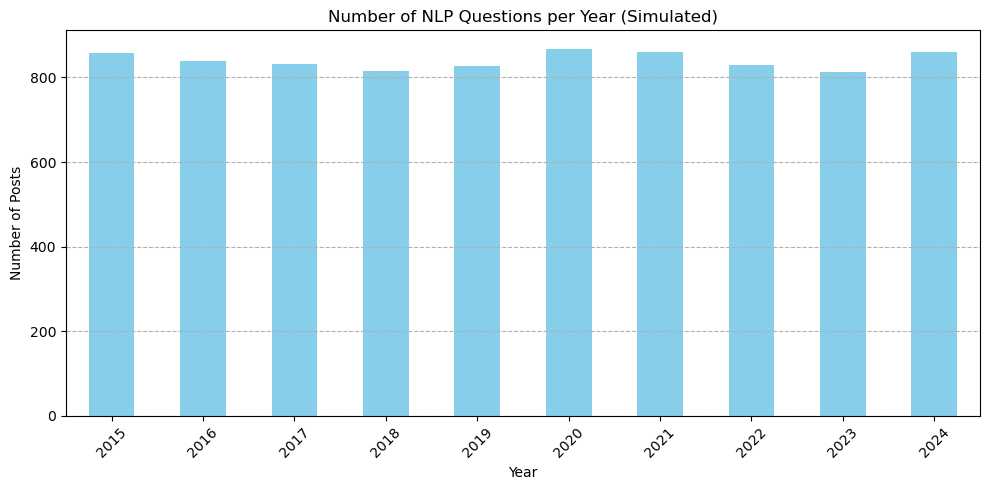

In [59]:
#plot number of posts per year
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df['year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of NLP Questions per Year (Simulated)")
plt.xlabel("Year")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [60]:
#Count answered and unanswered posts
answered_posts = df['accepted_answer'].notna().sum()
unanswered_posts = df['accepted_answer'].isna().sum()
total_posts = len(df)

print(f"Answered: {answered_posts} posts ({round((answered_posts/total_posts)*100, 2)}%)")
print(f"Unanswered: {unanswered_posts} posts ({round((unanswered_posts/total_posts)*100, 2)}%)")

Answered: 2534 posts (30.15%)
Unanswered: 5870 posts (69.85%)


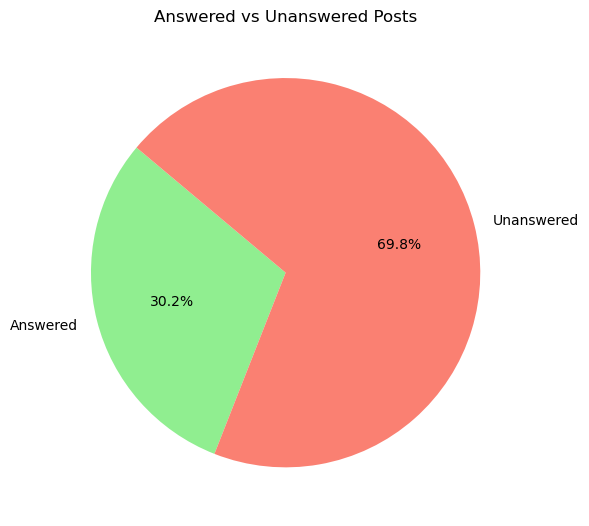

In [61]:
#Pie chart of answered vs unanswered
plt.figure(figsize=(6,6))
plt.pie([answered_posts, unanswered_posts], labels=['Answered', 'Unanswered'],
        autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon'])
plt.title("Answered vs Unanswered Posts")
plt.tight_layout()
plt.show()


In [62]:
#most used tag combinations
print("Top tag combinations:")
print(df['tags'].value_counts().head(10))


Top tag combinations:
tags
['python', 'nlp', 'nltk']                                 190
['python', 'nlp', 'spacy']                                170
['python', 'nlp']                                         163
['nlp']                                                   119
['nlp', 'stanford-nlp']                                   102
['java', 'nlp', 'stanford-nlp']                            70
['python', 'pandas', 'nlp']                                59
['nlp', 'spacy']                                           46
['python', 'regex', 'nlp']                                 42
['python', 'nlp', 'spacy', 'named-entity-recognition']     35
Name: count, dtype: int64


In [63]:
unanswered_df = df[df['accepted_answer'].isna()].copy()
unanswered_df['tags_list'] = unanswered_df['tags'].apply(lambda x: x.strip("[]").replace("'", "").split(', '))
#flatten all tags
flat_tags = [tag for sublist in unanswered_df['tags_list'] for tag in sublist]
tag_counts = Counter(flat_tags)
#create dataFrame for top 10 tags
tags_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)
print("Top 10 Tags in Unanswered Posts:")
print(tags_df.head(10))

Top 10 Tags in Unanswered Posts:
                  Tag  Count
2                 nlp   5742
7              python   2640
5                nltk    855
1    machine-learning    701
9        stanford-nlp    489
8                java    436
24              spacy    399
168        python-3.x    309
93                  r    301
68              regex    260


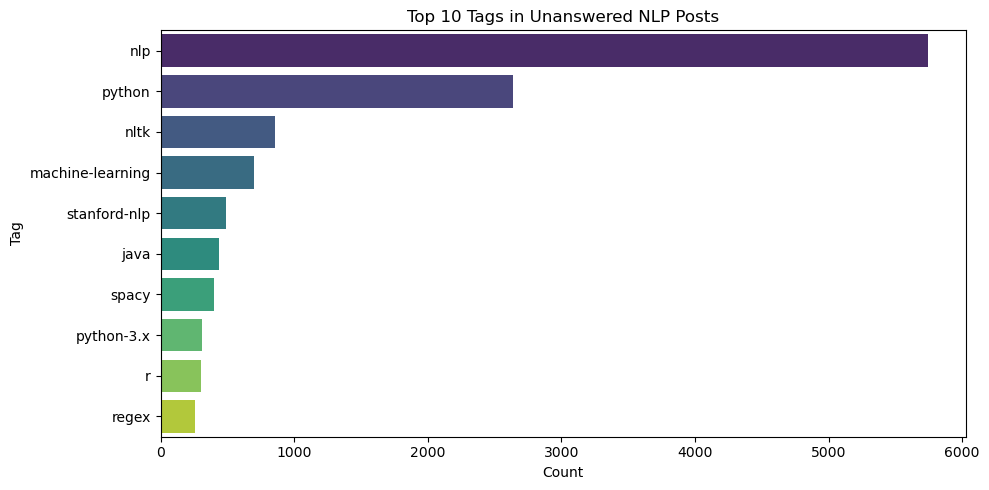

In [64]:
#Plot top 10 unanswered tags
plt.figure(figsize=(10,5))
sns.barplot(data=tags_df.head(10), x='Count', y='Tag', palette='viridis')
plt.title("Top 10 Tags in Unanswered NLP Posts")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

In [91]:
#filter answered posts
answered_df = df[df['accepted_answer'].notna()].copy()
#Calculate answer length in words
answered_df['answer_length'] = answered_df['answer_clean'].apply(lambda x: len(x.split()))
print(answered_df['answer_length'].describe())

count    2534.000000
mean      162.014207
std       202.881833
min         3.000000
25%        61.000000
50%       110.500000
75%       192.000000
max      4255.000000
Name: answer_length, dtype: float64


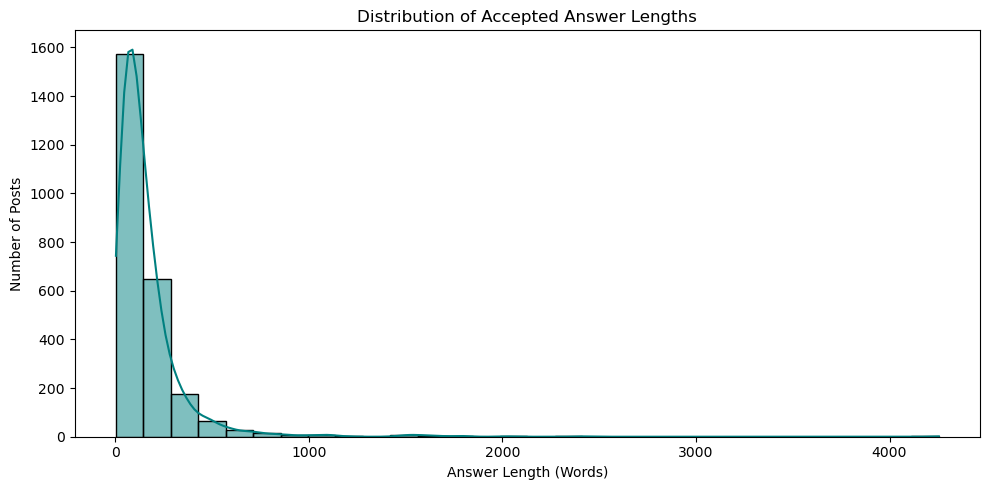

In [92]:
#plot answer length histogram
plt.figure(figsize=(10, 5))
sns.histplot(answered_df['answer_length'], bins=30, kde=True, color='teal')
plt.title("Distribution of Accepted Answer Lengths")
plt.xlabel("Answer Length (Words)")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

### Pre-Processing

In [66]:
#for cleaning the title column,we need to see original title
print("\nOriginal title:")
print(df['title'].iloc[0])


Original title:
How does the Google &quot;Did you mean?&quot; Algorithm work?


In [67]:
#remove html tags
df['title_clean'] = df['title'].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text())

C:\Users\aipro\AppData\Local\Temp\ipykernel_15096\3562314551.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['title_clean'] = df['title'].apply(lambda x: BeautifulSoup(str(x), "html.parser").get_text())


In [68]:
#convert to lowercase
df['title_clean'] = df['title_clean'].str.lower()

In [69]:
#remove numbers
df['title_clean'] = df['title_clean'].apply(lambda x: re.sub(r'\d+', '', x))


In [70]:
#remove punctuation
pattern = r'\W+'
df['title_clean'] = df['title_clean'].apply(lambda x: re.sub(pattern, ' ', x))


In [71]:
#remove stopwords
stop_words = set(stopwords.words('english'))
df['title_clean'] = df['title_clean'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))


In [72]:
print("Cleaned title:")
print(df['title_clean'].iloc[0])


Cleaned title:
google mean algorithm work


In [73]:
#cleaning the body
df['body_html_removed'] = df['body'].apply(lambda x: html.unescape(BeautifulSoup(str(x), "html.parser").get_text()) if pd.notnull(x) else '')
df['body_lower'] = df['body_html_removed'].str.lower()
df['body_clean'] = df['body_lower'].apply(lambda x: re.sub(r'\d+', '', x))  
df['body_clean'] = df['body_clean'].apply(lambda x: re.sub(r'\W+', ' ', x))


In [74]:
#cleaning accepted answer
df['answer_html_removed'] = df['accepted_answer'].apply(lambda x: html.unescape(BeautifulSoup(str(x), "html.parser").get_text()) if pd.notnull(x) else '')
df['answer_lower'] = df['answer_html_removed'].str.lower()
df['answer_lower'] = df['answer_lower'].apply(lambda x: re.sub(r'\d+', '', x))  # remove numbers
df['answer_clean'] = df['answer_lower'].apply(lambda x: re.sub(r'\W+', ' ', x))


In [75]:
#tokenise
df['title_tokens'] = df['title_clean'].apply(word_tokenize)
df['answer_tokens'] = df['answer_clean'].apply(word_tokenize)

print("Tokenised cleaned title:")
print(df['title_tokens'].iloc[0])



Tokenised cleaned title:
['google', 'mean', 'algorithm', 'work']


In [76]:
#show cleaned results
df[['title_clean', 'answer_clean']].head()
df[['title_tokens', 'answer_tokens']].head()



,title_tokens,answer_tokens
0,"[google, mean, algorithm, work]",[]
1,"[compute, similarity, two, text, documents]","[the, common, way, of, doing, this, is, to, tr..."
2,"[googletrans, stopped, working, error, nonetyp...","[update, this, issue, re, emerged, lately, app..."
3,"[difference, lemmatization, vs, stemming]",[]
4,"[determine, language, piece, text]",[]


In [77]:
#save preprocessed dataset
df.to_csv("nlp_preprocessed_dataset.csv", index=False)
print("Saved as: nlp_preprocessed_dataset.csv")


Saved as: nlp_preprocessed_dataset.csv


### WORDCLOUD

In [78]:
#joining all cleaned titles into one string
all_titles = ' '.join(df['title_clean'])
print(all_titles[:300])

google mean algorithm work compute similarity two text documents googletrans stopped working error nonetype object attribute group difference lemmatization vs stemming determine language piece text java stanford nlp part speech labels spacy find model en_core_web_sm windows python anaconda custom bi


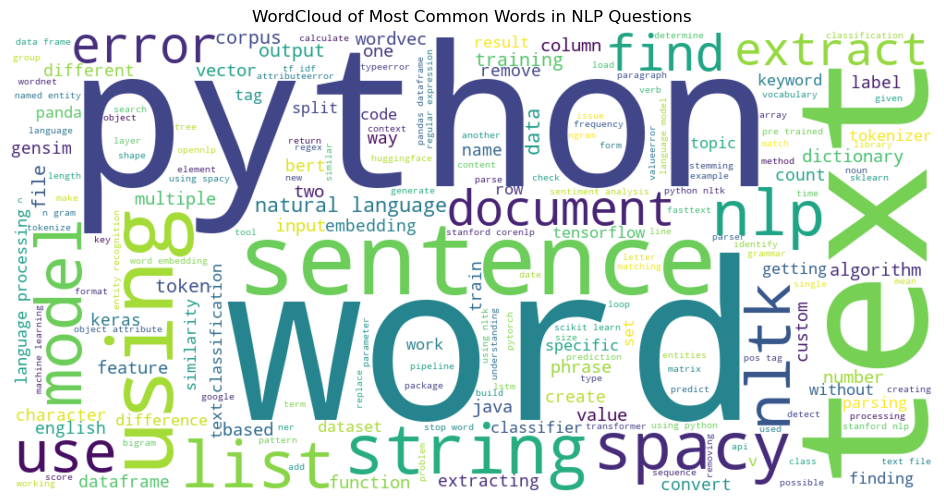

In [79]:
#make the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_titles)
#word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Most Common Words in NLP Questions")
plt.show()

In [80]:
#save wordcloud image 
wordcloud.to_file("wordcloud_title.png")
print("WordCloud image saved as: wordcloud_title.png")

WordCloud image saved as: wordcloud_title.png


### Categorisation

In [81]:
print("Categorising posts based on question titles...")


Categorising posts based on question titles...


In [82]:
category_list = []

for title in df['title_clean']:
    if "how to" in title or title.startswith("how"):
        category_list.append("Implementation")
    elif "what" in title or "why" in title:
        category_list.append("Conceptual")
    elif any(x in title for x in ["tokenize", "tokenizer", "lemmatize", "stemming"]):
        category_list.append("Text Preprocessing")
    elif "similarity" in title or "distance" in title:
        category_list.append("Text Similarity")
    elif "language" in title and "detect" in title:
        category_list.append("Language Detection")
    elif any(x in title for x in ["spacy", "nltk", "gensim", "transformers", "huggingface"]):
        category_list.append("Library Related")
    else:
        category_list.append("Other")

df['category'] = category_list

In [83]:
#View number of post in each category
print("Post count per category:")
print(df['category'].value_counts())



Post count per category:
category
Other                 6550
Library Related       1313
Text Preprocessing     288
Text Similarity        225
Language Detection      26
Conceptual               2
Name: count, dtype: int64


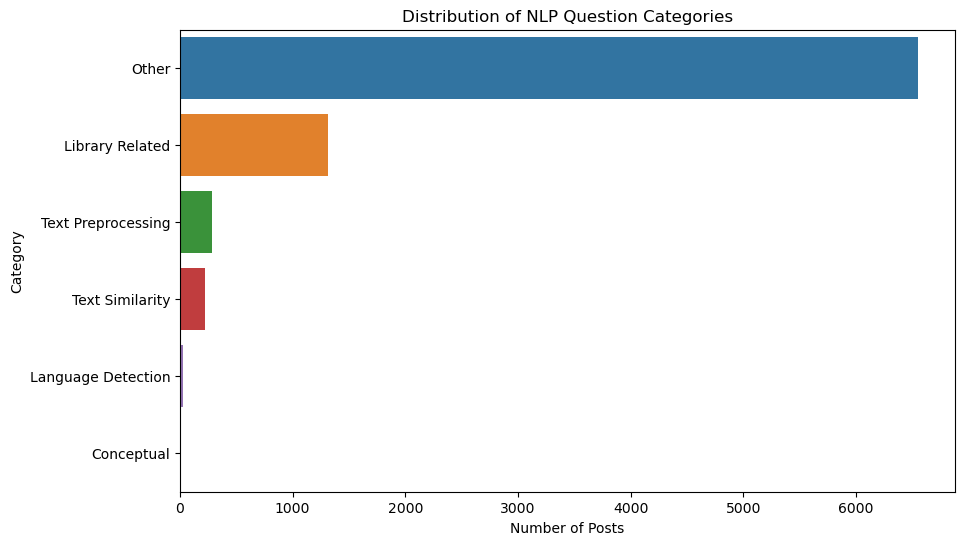

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title("Distribution of NLP Question Categories")
plt.xlabel("Number of Posts")
plt.ylabel("Category")
plt.show()


In [85]:
# showing 2 example questions from each category
for cat in df['category'].unique():
    print(f"Category: {cat}")
    print(df[df['category'] == cat]['title'].head(2).to_string(index=False))



Category: Other
How does the Google &quot;Did you mean?&quot; A...
googletrans stopped working with error &#39;Non...

Category: Text Similarity
How to compute the similarity between two text ...
Calculate cosine similarity given 2 sentence st...

Category: Text Preprocessing
What is the difference between lemmatization vs...
      What does Keras Tokenizer method exactly do?

Category: Library Related
spaCy: Can&#39;t find model &#39;en_core_web_sm...
                   Creating a new corpus with NLTK

Category: Language Detection
How to detect language of user entered text?
                 NLTK and language detection

Category: Conceptual
How to split a conversation on WhatsApp in mult...
Date pattern for WhatsApp chat text file that h...


In [86]:
#Show total number of posts categorised 
print("Total number of posts categorised:", df['category'].notna().sum())



Total number of posts categorised: 8404


In [87]:
#show a random sample of titles and their categories
df[['title', 'category']].sample(10)


,title,category
7188,Python : How to optimize calculations?,Other
4322,Difference between tag and class in Stanford NER,Other
101,Target modules for applying PEFT / LoRA on dif...,Other
1039,Spacy tokenizer with only &quot;Whitespace&quo...,Text Preprocessing
313,List of Natural Language Processing Tools in R...,Other
7027,Stemming words in a Python list,Text Preprocessing
169,Incompatible initial and maximum heap sizes sp...,Other
290,nltk stemmer: string index out of range,Library Related
1065,"ERROR: Could not build wheels for spacy, which...",Library Related
1628,Extracting clause from a Penn Treebank-formatt...,Other


In [88]:
#Save final dataset with assigned categories
df.to_csv("nlp_categorised_dataset.csv", index=False)
print("File saved as: nlp_categorised_dataset.csv")


File saved as: nlp_categorised_dataset.csv


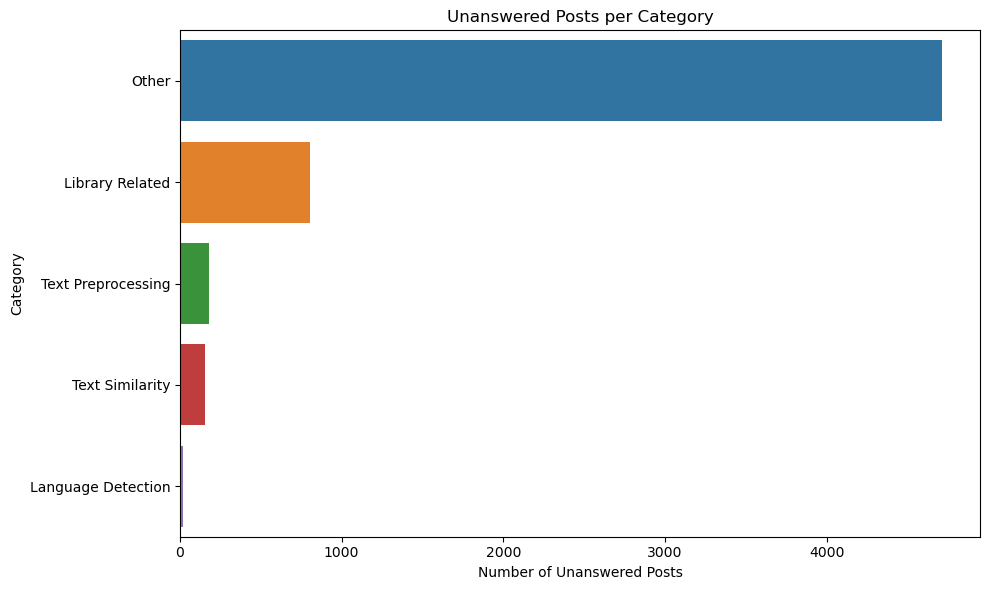

In [89]:
#count unanswered posts in each category
unanswered_counts = df[df['accepted_answer'].isna()]['category'].value_counts()

#Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=unanswered_counts.values, y=unanswered_counts.index)
plt.title("Unanswered Posts per Category")
plt.xlabel("Number of Unanswered Posts")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


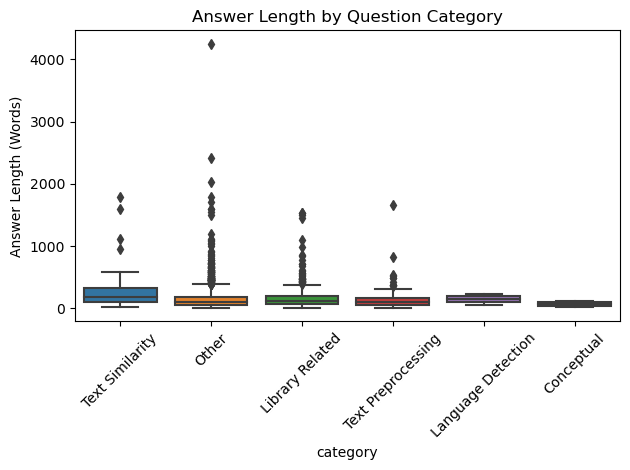

In [94]:
#boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='answer_length', data=answered_df)
plt.title("Answer Length by Question Category")
plt.xticks(rotation=45)
plt.ylabel("Answer Length (Words)")
plt.tight_layout()
plt.show()
